<a href="https://colab.research.google.com/github/ArpanSM/Object-Detection-and-Instance-Segmentaion/blob/master/COVID_19_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Approach
- Loading Data from Github
- Splittting Data into train-val-test
- Usung Pre-trained CNN to classify faces with and without masks.
- Hyperparameter tuning in pre-trained network for reducing overfitting
- Loading Face recognition haarcascade file
- Detecting Face and classifying them into 'with facemask' or 'without facemask'
- Using OpenCV to draw bounding boxes around faces and showcasing the output text above it.
- Same procedure for video file.


##Loading and Splitting Data

In [1]:
!git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1638 (delta 9), reused 0 (delta 0), pack-reused 1604
Receiving objects: 100% (1638/1638), 75.94 MiB | 38.44 MiB/s, done.
Resolving deltas: 100% (20/20), done.


Get the data folder into the /content/ directory

In [2]:
import shutil
shutil.move('/content/observations/experiements/data','/content/')

'/content/data'

using split_folders library, we divided our data into train, val and test in the ratio 70-20-10

In [3]:
!pip install split-folders
import split_folders
split_folders.ratio('/content/data',output='dataset',seed=1137, ratio=(.7,.2,.1))

Copying files: 1376 files [00:00, 7019.49 files/s]


Loading the required Keras libraries

In [4]:
!pip install livelossplot
from livelossplot import PlotLossesKeras
import numpy as np
import keras
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from keras.initializers import glorot_uniform

Using TensorFlow backend.


##Training

We would be using pre-trained MobileNetV2 model, for faster and more accurate predictions.

In [5]:
img_size = 224
from keras.applications.mobilenet_v2 import MobileNetV2
model_finetuned = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))

9412608/9406464 [==============================] - 0s 0us/step


In [6]:
import os
len(os.listdir('/content/dataset/train/with_mask/'))

482

In [0]:
train_data_dir = '/content/dataset/train'
val_data_dir = '/content/dataset/val'
test_data_dir ='/content/dataset/test'
nb_train_samples = 480+482
nb_val_samples = 138+137
epochs = 10
batch_size = 8
num_class = 2

Data Augmentation

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = val_datagen.flow_from_directory(val_data_dir,
                                                        target_size=(img_size,img_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator=test_datagen.flow_from_directory(test_data_dir,
                                                target_size=(img_size,img_size),
                                                batch_size=1,
                                                class_mode='categorical')

Found 962 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 139 images belonging to 2 classes.


In [0]:
if(num_class==1):
  actv = "sigmoid"
  loss = "binary_crossentropy"
else:
  actv = "softmax"
  loss = "categorical_crossentropy"

Define the output layer from the pre-trained model according to the our number of class.

In [0]:
model_finetuned = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
#x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(127), bias_initializer='zeros')(x)
x = Dropout(rate = 0.5)(x)
x = Dropout(rate = 0.25)(x)
#x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

Training

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.00005,
                             beta_1=0.9,
                             beta_2=0.999,
                             amsgrad=False)

model_finetuned = Model(inputs=model_finetuned.input, 
                        outputs=predictions)

model_finetuned.compile(optimizer=adam,
                        loss = loss,
                        metrics=['accuracy'])

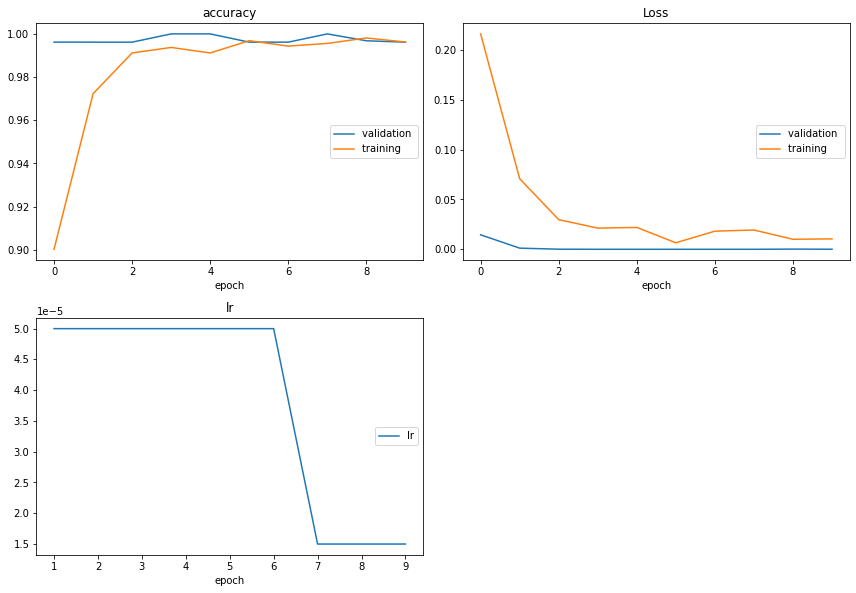

accuracy
	validation       	 (min:    0.996, max:    1.000, cur:    0.996)
	training         	 (min:    0.900, max:    0.998, cur:    0.996)
Loss
	validation       	 (min:    0.000, max:    0.015, cur:    0.000)
	training         	 (min:    0.007, max:    0.216, cur:    0.010)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00010: val_loss did not improve from 0.00000


In [58]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=3,
                              min_lr=0.000001)

checkpoint = ModelCheckpoint("./mobilenet-model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)

callbacks = [PlotLossesKeras(),reduce_lr,earlystop,checkpoint]

history = model_finetuned.fit_generator(train_generator,
                                        steps_per_epoch=200,
                                        epochs=10,
                                        validation_data=validation_generator,
                                        validation_steps=200,
                                        callbacks = callbacks,
                                        use_multiprocessing=False)

In [47]:
# load weights into new model
model_finetuned.load_weights("/content/mobilenet-model.08-0.01-1.00.h5")
test_generator.reset()
pred = model_finetuned.predict_generator(test_generator, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(labels)

139/139 [==============================] - 3s 19ms/step
{0: 'with_mask', 1: 'without_mask'}


##Testing

Downloading `haarcascade_frontalface_default.xml` for face detection

In [0]:
from keras.models import load_model
import cv2
import numpy as np

In [14]:
!wget https://www.dropbox.com/s/1vs0zjuzvfpsv7j/haarcascade_frontalface_default.xml

--2020-06-11 05:22:53--  https://www.dropbox.com/s/1vs0zjuzvfpsv7j/haarcascade_frontalface_default.xml
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1vs0zjuzvfpsv7j/haarcascade_frontalface_default.xml [following]
--2020-06-11 05:22:54--  https://www.dropbox.com/s/raw/1vs0zjuzvfpsv7j/haarcascade_frontalface_default.xml
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd912ff5e130e91820222fdd7ff.dl.dropboxusercontent.com/cd/0/inline/A5bzPsb613cj-fUqH4NksIIaHu9K5XgPbrvNaqV327L--QqXIy0ggkzPPp3-d6xpMA20yRsfMhWuQdpcRCvFBPjKzA3Sei6gg4eoiVMKkIMweW4GJ6YyRAvnqkDr4_B5dO8/file# [following]
--2020-06-11 05:22:54--  https://ucd912ff5e130e91820222fdd7ff.dl.dropboxusercontent.com/cd/0/inline/A5bzPsb613cj-fUqH4NksIIaHu9K5XgPbrvNaqV327L--

Loading the trained model and Haarcascade file.

In [0]:
model = load_model('/content/mobilenet-model.07-0.00-1.00.h5')
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

Predicting on the 2 test images

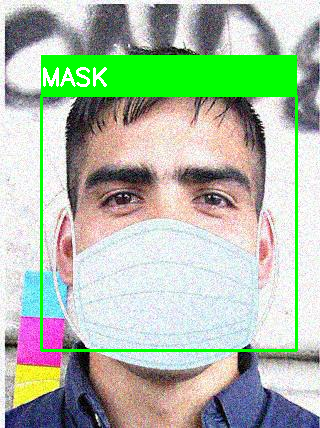

In [60]:
img = cv2.imread('/content/dataset/test/with_mask/augmented_image_43.jpg')
faces=face_clsfr.detectMultiScale(img,1.3,5)  

from google.colab.patches import cv2_imshow
for (x,y,w,h) in faces:
    face_img=img[y:y+w,x:x+w]
    resized=cv2.resize(face_img,(224,224))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,224,224,3))
    result=model.predict(reshaped)

    label=np.argmax(result,axis=1)[0]
  
    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    
    
cv2_imshow(img)

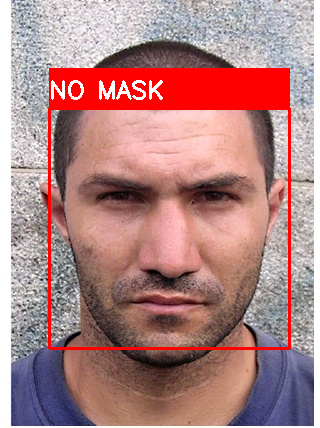

In [61]:
img = cv2.imread('/content/dataset/test/without_mask/176.jpg')
faces=face_clsfr.detectMultiScale(img,1.3,5)  

from google.colab.patches import cv2_imshow
for (x,y,w,h) in faces:
    face_img=img[y:y+w,x:x+w]
    resized=cv2.resize(face_img,(224,224))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,224,224,3))
    result=model.predict(reshaped)

    label=np.argmax(result,axis=1)[0]
  
    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    
    
cv2_imshow(img)

Predicting on Videos

In [19]:
cd /content/

/content


Upload a video of your choice

In [20]:
!mkdir video
%cd video
# upload the .json file.
from google.colab import files
uploaded = files.upload()
%cd /content/

/content/video


Saving Covid_video.mp4 to Covid_video.mp4
/content


In [38]:
cd /content/

/content


View our video file

In [22]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/video/Covid_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Extracting frames from the video file.

In [23]:
!mkdir test1
%cd test1
import math
videoFile = "/content/video/Covid_video.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = 'img' +  str(int(x)) + ".jpg";x+=1
        cv2.imwrite(filename, frame)
cap.release()
%cd /content/

/content/test1
/content


Predicting on the extracted frames

In [39]:
!mkdir output
%cd output
import cv2
from pathlib import Path
import glob
out_path = '/content/output'
count = 0
for imagepath in glob.glob("/content/test1/*.jpg"):       
  img=cv2.imread(str(imagepath))
  faces=face_clsfr.detectMultiScale(img,1.3,5)
  for (x,y,w,h) in faces:
    face_img=img[y:y+w,x:x+w]
    resized=cv2.resize(face_img,(224,224))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,224,224,3))
    result=model.predict(reshaped)
    #print(result)
    label=np.argmax(result,axis=1)[0]
  
    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
  cv2.imwrite('img%d.jpg'%count,img)
  count += 1
  #print(imagepath[9:])
%cd /content/

/content/output
/content


Coverting all frames into Video file

In [40]:
import cv2
import os
image_folder = '/content/output/'
video_name = '/content/video.avi'
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, 0, 1, (width,height))
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
cv2.destroyAllWindows()
video.release()

%cd /content/
!ffmpeg -i video.avi output.mp4 
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/content
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libx